# DATA FOUNDATION

In [1]:
import pandas as pd
import numpy as np 
import os
import gc # Để giải phóng RAM

BASE_DIR = "/MALLORN-Astronomical-Classification-Challenge/data/raw"

R_COEFFS = {'u': 4.239, 'g': 3.303, 'r': 2.285, 'i': 1.698, 'z': 1.263, 'y': 1.086}

In [2]:
def load_train_log(base_dir):
    train_log_path  = os.path.join(base_dir, 'train_log.csv')
    if not os.path.exists(train_log_path):
        raise FileNotFoundError("Không tìm thấy file train_log")
    
    df_train_log = pd.read_csv(train_log_path)
    return df_train_log

In [3]:
def apply_sanity_checks(df):
    n_original = len(df)

    # 1. Xứ lý NaN
    # Nếu Flux hoặc Flux_err bị NaN -> Xóa dòng vì dữ liệu vô nghĩa
    df = df.dropna(subset=['Flux', 'Flux_err', 'Flux_corrected', 'Flux_err_corrected'])

    # Nếu EBV bị NaN, điền bằng 0 (coi như không có bụi) để tránh lỗi tính toán
    if 'EBV' in df.columns:
        df['EBV'] = df['EBV'].fillna(0)

    # 2. Xử lý Flux âm
    # Không xóa FLux âm nhưng kiểm kê nó
    n_negative = (df['Flux_corrected'] < 0).sum()

    # 3. Sắp xếp thời gian
    df = df.sort_values(by=['object_id', 'Time (MJD)'], ascending=[True, True])
    df = df.reset_index(drop=True)

    n_dropped = n_original - len(df)
    if n_dropped > 0:
        print(f"   Đã loại bỏ {n_dropped} dòng chứa NaN.")
    if n_negative > 0:
        print(f"   Lưu ý: Có {n_negative} điểm đo có Flux Âm (vẫn giữ lại).")
    
    return df

In [4]:
def process_one_split(split_name, df_train_log, base_dir):
    print(f"\n Đang xử lý: {split_name}...")
    
    train_lc_path = os.path.join(base_dir, split_name, "train_full_lightcurves.csv")
    
    df_meta_split = df_train_log[df_train_log['split'] == split_name].copy()
    
    df_train_lc = pd.read_csv(train_lc_path)

    df_train_lc_merged = df_train_lc.merge(
        df_meta_split[['object_id', 'EBV', 'target']],
        on='object_id',
        how='inner'
    )

    df_train_lc_merged['R_factor'] = df_train_lc_merged['Filter'].map(R_COEFFS)
    correction = 10 ** (0.4 * df_train_lc_merged['R_factor'] * df_train_lc_merged['EBV'])
    df_train_lc_merged['Flux_corrected'] = df_train_lc_merged['Flux'] * correction
    df_train_lc_merged['Flux_err_corrected'] = df_train_lc_merged['Flux_err'] * correction

    df_train_lc_clean = apply_sanity_checks(df_train_lc_merged)
    del df_train_lc, df_train_lc_merged
    gc.collect()

    print(f"   -> Hoàn tất {split_name}")
    return df_train_lc_clean

In [18]:
df_log_global = load_train_log(BASE_DIR)

# Test trên split_01
df_result = process_one_split('split_01', df_log_global, BASE_DIR)

if df_result is not None:
    print("\n--- KIỂM TRA DỮ LIỆU CUỐI CÙNG (5 dòng đầu) ---")
    print(f"Kích thước: {df_log_global.columns}")
    # Kiểm tra xem thời gian đã tăng dần chưa
    display(df_result[['object_id', 'Time (MJD)', 'Flux', 'Flux_corrected']].head(10))
    
    # Kiểm tra thống kê NaN
    print("\nSố lượng NaN còn lại (phải là 0):")
    print(df_result.isna().sum())


 Đang xử lý: split_01...
   Đã loại bỏ 11 dòng chứa NaN.
   Lưu ý: Có 10254 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_01

--- KIỂM TRA DỮ LIỆU CUỐI CÙNG (5 dòng đầu) ---
Kích thước: Index(['object_id', 'Z', 'Z_err', 'EBV', 'SpecType', 'English Translation',
       'split', 'target'],
      dtype='object')


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


,object_id,Time (MJD),Flux,Flux_corrected
0,Dornhoth_fervain_onodrim,63314.4662,-1.630159,-1.852686
1,Dornhoth_fervain_onodrim,63314.4662,-1.424537,-1.590222
2,Dornhoth_fervain_onodrim,63327.6691,-1.409011,-1.673503
3,Dornhoth_fervain_onodrim,63327.6691,-1.558067,-1.770754
4,Dornhoth_fervain_onodrim,63340.8720,-2.057437,-2.443647
5,Dornhoth_fervain_onodrim,63380.4806,-0.855074,-1.194911
6,Dornhoth_fervain_onodrim,63380.4806,-1.021596,-1.287713
7,Dornhoth_fervain_onodrim,63420.0891,-1.073603,-1.353268
8,Dornhoth_fervain_onodrim,63420.0891,-0.472944,-0.660909
9,Dornhoth_fervain_onodrim,63424.4901,-1.080999,-1.283918



Số lượng NaN còn lại (phải là 0):
object_id             0
Time (MJD)            0
Flux                  0
Flux_err              0
Filter                0
EBV                   0
target                0
R_factor              0
Flux_corrected        0
Flux_err_corrected    0
dtype: int64


# FEATURE ENGINEERING

STATISTICAL FEATURES

In [6]:
def generate_statistical_features(df):
    print("Đang tạo: Statistical & Percentiles Features....")

    # 1. Định nghĩa các hàm thống kê
    aggregations = {
        'Flux_corrected': [
            'mean', 'std', 'max', 'min',
            ('q05', lambda x: x.quantile(0.05)), # Phân vị 5% (thay cho Min để tránh nhiễu)
            ('q25', lambda x: x.quantile(0.25)),
            ('q75', lambda x: x.quantile(0.75)),
            ('q95', lambda x: x.quantile(0.95)), # Phân vị 95% (thay cho Max để tránh nhiễu)
            'skew', # Độ lệch phân phối (quan trọng cho TDE)
            'count' # Số lượng điểm đo
        ],
        'Flux': ['max'], # Giữ lại max flux gốc để tham chiếu
        'Flux_err': ['mean'] # Sai số trung bình (đánh giá chất lượng đo)
    }

    # 2. Groupby và Aggregation (Thực hiện song song cho tất cả object)
    # Biến đổi bảng Long-fomr thành bảng thống kê sơ bộ
    df_agg = df.groupby(['object_id', 'Filter']).agg(aggregations)

    # 3. Làm phảng MultiIndex Columns
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    # 4. Unstack (Xoay trục Filter thành cột)
    df_features = df_agg.unstack('Filter')
    df_features.columns = [f"{filter_name}_{feature}" for feature, filter_name in df_features.columns]

    # 5. Tính các đặc trưng "Global" (Tổng hợp trên mọi band)
    global_agg = df.groupby('object_id')['Flux_corrected'].agg([
        ('global_max', 'max'),
        ('global_mean', 'mean'),
        ('global_std', 'std')
    ])

    # Ghép global vào bảng features
    df_features = df_features.join(global_agg)

    # 6. Xử lý NaN sinh ra do Unstack
    # (Ví dụ: Object A không có dữ liệu filter 'u', sẽ sinh ra NaN tại các cột u_...)
    # Chiến thuật: 
    # - Với Mean, Max, Min, Quantile: Fill = 0 (coi như tối đen)
    # - Với Count: Fill = 0
    df_features = df_features.fillna(0)

    print(f"✅ Hoàn thành Nhóm 1! Kích thước: {df_features.shape}")
    return df_features

In [7]:
df_features_g1 = generate_statistical_features(df_result)

# Xem thử 5 cột đầu tiên để kiểm tra định dạng tên
print("\n--- Mẫu các đặc trưng vừa tạo ---")
display(df_features_g1.iloc[:5, :10]) # Xem 10 cột đầu

# Kiểm tra xem có cột skew nào (độ lệch)
skew_cols = [c for c in df_features_g1.columns if 'skew' in c]
print(f"\nĐã tạo {len(skew_cols)} cột Skewness (ví dụ: {skew_cols[0]})")

Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)

--- Mẫu các đặc trưng vừa tạo ---


,g_Flux_corrected_mean,i_Flux_corrected_mean,r_Flux_corrected_mean,u_Flux_corrected_mean,y_Flux_corrected_mean,z_Flux_corrected_mean,g_Flux_corrected_std,i_Flux_corrected_std,r_Flux_corrected_std,u_Flux_corrected_std
object_id,,,,,,,,,,
Dornhoth_fervain_onodrim,-0.523170,2.507891,1.354417,0.897305,-0.448582,1.442674,0.949155,7.521850,4.080687,1.756665
Dornhoth_galadh_ylf,0.214970,0.387165,0.310346,0.033881,0.748245,0.563584,0.432050,1.059712,0.742890,0.707609
Elrim_melethril_thul,3.141294,6.419646,4.381228,0.057594,0.058178,7.847825,2.504693,7.115146,3.270901,3.117768
Ithil_tobas_rodwen,0.288862,0.454172,0.445994,0.160318,0.347413,0.538618,0.362132,0.640980,0.536924,0.462454
Mirion_adar_Druadan,0.055118,0.420397,0.236805,-0.017642,0.305273,0.316992,0.959285,1.478422,1.218722,0.530510



Đã tạo 6 cột Skewness (ví dụ: g_Flux_corrected_skew)


MORPHOLOGY FEATURES

In [8]:
def generate_morphology_features(df_clean, df_features_g1):
    print("   Đang tạo: Morphology Features")

    # index của dòng có Flux lớn nhất cho mỗi object/filter
    idx_max = df_clean.groupby(['object_id', 'Filter'])['Flux_corrected'].idxmax()

    # index của dòng đầu tiên và dòng cuối cùng (theo thời gian)
    idx_first = df_clean.groupby(['object_id', 'Filter'])['Time (MJD)'].idxmin()
    idx_last = df_clean.groupby(['object_id', 'Filter'])['Time (MJD)'].idxmax()

     # Trích xuất dữ liệu tại các điểm mốc
    df_peaks = df_clean.loc[idx_max][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])
    df_starts = df_clean.loc[idx_first][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])
    df_ends = df_clean.loc[idx_last][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])

    df_peaks.columns = ['Time_peak', 'Flux_peak']
    df_starts.columns = ['Time_start', 'Flux_start']
    df_ends.columns = ['Time_end', 'Flux_end']

    # Ghép lại thành một bảng cho morphology
    df_morp = pd.concat([df_peaks, df_starts, df_ends], axis=1)

    # Tính Time, Slope
    df_morp['Rise_time'] = df_morp['Time_peak'] - df_morp['Time_start']
    df_morp['Fall_time'] = df_morp['Time_end'] - df_morp['Time_peak']
    df_morp['Rise_slope'] = (df_morp['Flux_peak'] - df_morp['Flux_start']) / (df_morp['Rise_time'] + 0.1)
    df_morp['Fall_slope'] = (df_morp['Flux_end'] - df_morp['Flux_peak']) / (df_morp['Fall_time'] + 0.1)
    
    cols_time_slope = ['Rise_time', 'Fall_time', 'Rise_slope', 'Fall_slope']
    df_morp_ts = df_morp[cols_time_slope].unstack('Filter')
    df_morp_ts.columns = [f"{filter_name}_{feat}" for feat, filter_name in df_morp_ts.columns]

    # Tính Percent Amplitude
    amp_features = []
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    
    for f in filters:
        col_max = f"{f}_Flux_corrected_max"
        col_min = f"{f}_Flux_corrected_min"
        col_mean = f"{f}_Flux_corrected_mean"

        amp_series = (df_features_g1[col_max] - df_features_g1[col_min]) / (df_features_g1[col_mean] + 1e-6)
        amp_df = pd.DataFrame({f"{f}_percent_amplitude": amp_series})
        amp_features.append(amp_df)
    df_morp_amp = pd.concat(amp_features, axis=1)

    # Tính Kurtosis
    df_morp_kurt = df_clean.groupby(['object_id', 'Filter'])['Flux_corrected'].apply(lambda x: x.kurt()).unstack('Filter')
    df_morp_kurt.columns = [f"{f}_kurtosis" for f in df_morp_kurt.columns]

    # Tính Stetson K
    mean_cols = [c for c in df_features_g1.columns if 'mean' in c and 'Flux_corrected' in c and 'global' not in c]
    df_means = df_features_g1[mean_cols].copy()
    df_means.columns = [c.split('_')[0] for c in df_means.columns]

    df_means_flat = df_means.stack().reset_index()
    df_means_flat.columns = ['object_id', 'Filter', 'mean_flux']
    df_stetson = pd.merge(df_clean, df_means_flat, on=['object_id', 'Filter'], how='left')

    df_stetson['delta'] = (df_stetson['Flux_corrected'] - df_stetson['mean_flux']) / (df_stetson['Flux_err_corrected'] + 1e-6)
    
    df_stetson['abs_delta'] = df_stetson['delta'].abs()
    df_stetson['delta_sq'] = df_stetson['delta'] ** 2

    g = df_stetson.groupby(['object_id', 'Filter'])
    mean_abs_delta = g['abs_delta'].mean()
    mean_delta_sq = g['delta_sq'].mean()
    stetson_k = mean_abs_delta / (np.sqrt(mean_delta_sq) + 1e-6)

    df_morp_stetson = stetson_k.unstack('Filter')
    df_morp_stetson.columns = [f"{f}_stetson_k" for f in df_morp_stetson.columns]


    # Tạo bảng morphology features
    df_morp_final = df_morp_ts.join([df_morp_amp, df_morp_kurt, df_morp_stetson])

    # Xử lý NaN nếu có
    df_morp_final = df_morp_final.fillna(0)

    print(f"Hoàn thành Nhóm 2! Kích thước: {df_morp_final.shape}")
    return df_morp_final

In [9]:
df_features_g2 = generate_morphology_features(df_result, df_features_g1)

print("\n--- Mẫu đặc trưng Hình thái ---")
display(df_features_g2.iloc[:5, :8]) # Xem 8 cột đầu

   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)

--- Mẫu đặc trưng Hình thái ---


,g_Rise_time,i_Rise_time,r_Rise_time,u_Rise_time,y_Rise_time,z_Rise_time,g_Fall_time,i_Fall_time
object_id,,,,,,,,
Dornhoth_fervain_onodrim,444.4963,444.4964,400.4868,61.6134,475.3031,457.6993,250.8544,699.7516
Dornhoth_galadh_ylf,1504.5906,1473.7800,1453.2394,682.9712,1558.5094,1537.9690,785.6737,798.5114
Elrim_melethril_thul,0.0000,730.9880,0.0000,444.6663,767.8628,620.3637,498.8939,472.8647
Ithil_tobas_rodwen,1119.8792,1119.8792,2451.7049,2781.0811,2726.6625,1094.1019,1729.9413,1729.9413
Mirion_adar_Druadan,762.0820,1104.4667,996.2289,713.4855,1153.0632,629.5460,1422.5531,1080.1684


COLOR FEATURES

In [10]:
def generate_color_features(df_features_g1):
    print("   Đang tạo: Color Features")

    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    new_features = []

    for i in range(len(filters) - 1):
        f1 = filters[i]
        f2 = filters[i+1]

        col_f1_mean = f"{f1}_Flux_corrected_mean"
        col_f2_mean = f"{f2}_Flux_corrected_mean"

        ratio_mean = df_features_g1[col_f1_mean] / (df_features_g1[col_f2_mean] + 1e-6)
        diff_mean = df_features_g1[col_f1_mean] - df_features_g1[col_f2_mean]

        col_f1_max = f"{f1}_Flux_corrected_max"
        col_f2_max = f"{f2}_Flux_corrected_max"

        ratio_max = df_features_g1[col_f1_max] / (df_features_g1[col_f2_max] + 1e-6)
        diff_max = df_features_g1[col_f1_max] - df_features_g1[col_f2_max]

        temp_df = pd.DataFrame({
            f'{f1}_{f2}_mean_ratio': ratio_mean,
            f'{f1}_{f2}_mean_diff': diff_mean,
            f'{f1}_{f2}_max_ratio': ratio_max,
            f'{f1}_{f2}_max_diff': diff_max
        }, index=df_features_g1.index)

        new_features.append(temp_df)

    f_start, f_end = 'u', 'y'
    col_start = f"{f_start}_Flux_corrected_mean"
    col_end = f"{f_end}_Flux_corrected_mean"

    blue_red_ratio = df_features_g1[col_start] / (df_features_g1[col_end] + 1e-6)
    temp_extreme = pd.DataFrame({f'{f_start}_{f_end}_mean_ratio': blue_red_ratio}, index=df_features_g1.index)
    new_features.append(temp_extreme)

    df_colors = pd.concat(new_features, axis=1)
    df_colors = df_colors.replace([np.inf, -np.inf], 0).fillna(0)

    print(f"Hoàn thành Nhóm 3! Kích thước: {df_colors.shape}")
    return df_colors


In [11]:
df_features_g3 = generate_color_features(df_features_g1)
    
print("\n--- Mẫu đặc trưng Màu sắc (u/g, g/r...) ---")
display(df_features_g3.iloc[:5, :5]) 

   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)

--- Mẫu đặc trưng Màu sắc (u/g, g/r...) ---


,u_g_mean_ratio,u_g_mean_diff,u_g_max_ratio,u_g_max_diff,g_r_mean_ratio
object_id,,,,,
Dornhoth_fervain_onodrim,-1.715132,1.420475,2.932089,2.658946,-0.386269
Dornhoth_galadh_ylf,0.157608,-0.181089,0.891903,-0.161195,0.692675
Elrim_melethril_thul,0.018334,-3.083700,0.481356,-3.768502,0.716989
Ithil_tobas_rodwen,0.554996,-0.128544,1.186430,0.264779,0.647682
Mirion_adar_Druadan,-0.320078,-0.072761,0.376521,-1.101521,0.232757


In [12]:
def merge_all_features(df_log_split, df_g1, df_g2, df_g3):
    print("Đang hợp nhất 3 nhóm feature đầu tiên...")

    X_features = pd.concat([df_g1, df_g2, df_g3],axis=1)
    df_final = df_log_split.set_index('object_id').join(X_features, how='inner')

    return df_final

In [13]:
df_final_train = merge_all_features(df_result, df_features_g1, df_features_g2, df_features_g3)

print("\n🎉🎉🎉 DỮ LIỆU HUẤN LUYỆN HOÀN CHỈNH (BASELINE) 🎉🎉🎉")
print(f"Kích thước cuối cùng: {df_final_train.shape}")
print("Các cột Metadata quan trọng:", [c for c in df_final_train.columns if c in ['Z', 'Z_err', 'target', 'SpecType']])

display(df_final_train.head(3))

Đang hợp nhất 3 nhóm feature đầu tiên...

🎉🎉🎉 DỮ LIỆU HUẤN LUYỆN HOÀN CHỈNH (BASELINE) 🎉🎉🎉
Kích thước cuối cùng: (26313, 147)
Các cột Metadata quan trọng: ['target']


,Time (MJD),Flux,Flux_err,Filter,EBV,target,R_factor,Flux_corrected,Flux_err_corrected,g_Flux_corrected_mean,...,r_i_max_diff,i_z_mean_ratio,i_z_mean_diff,i_z_max_ratio,i_z_max_diff,z_y_mean_ratio,z_y_mean_diff,z_y_max_ratio,z_y_max_diff,u_y_mean_ratio
object_id,,,,,,,,,,,,,,,,,,,,,
Dornhoth_fervain_onodrim,63314.4662,-1.630159,0.365777,z,0.11,0,1.263,-1.852686,0.415708,-0.52317,...,-14.025222,1.738362,1.065217,0.957604,-1.206858,-3.216081,1.891256,4.346994,21.917932,-2.000316
Dornhoth_fervain_onodrim,63314.4662,-1.424537,1.059526,y,0.11,0,1.086,-1.590222,1.182757,-0.52317,...,-14.025222,1.738362,1.065217,0.957604,-1.206858,-3.216081,1.891256,4.346994,21.917932,-2.000316
Dornhoth_fervain_onodrim,63327.6691,-1.409011,0.321132,i,0.11,0,1.698,-1.673503,0.381413,-0.52317,...,-14.025222,1.738362,1.065217,0.957604,-1.206858,-3.216081,1.891256,4.346994,21.917932,-2.000316


# PROCESS 20 SPLITS (ONLY 3 FEATURE GROUPS)

In [14]:
from tqdm import tqdm

PROCESSED_DIR = "/MALLORN-Astronomical-Classification-Challenge/data/processed"
OUTPUT_FILE = "processed_train_full_lc.csv"

df_train_log = pd.read_csv(os.path.join(BASE_DIR, "train_log.csv"))
processed_chunks = []

print("--- Bắt đầu xử lý 20 splits---")

for i in range(1, 21):
    split_name = f"split_{i:02d}"
    print(f"Đang xử lý: {split_name} ({i}/20)...")

    df_clean = process_one_split(split_name, df_train_log, BASE_DIR)
    if df_clean is None:
        continue

    df_g1 = generate_statistical_features(df_clean)
    df_g2 = generate_morphology_features(df_clean, df_g1)
    df_g3 = generate_color_features(df_g1)

    current_ids = df_g1.index
    df_train_log_tmp = df_train_log[df_train_log['object_id'].isin(current_ids)].copy()

    df_chunk_final = merge_all_features(df_train_log_tmp, df_g1, df_g2, df_g3)
    processed_chunks.append(df_chunk_final)

    print(f"   -> Xử lý xong {split_name}. Kích thước chunk: {df_chunk_final.shape}")

    # Dọn dẹp RAM
    del df_clean, df_g1, df_g2, df_g3, df_chunk_final, df_train_log_tmp
    gc.collect()

print("Đang ghép nối tất cả các splits...")
if (len(processed_chunks) > 0):
    df_final_train_lc = pd.concat(processed_chunks, axis=0)
    print(f"Tổng kích thước: {df_final_train_lc.shape}")
    print(f"Tổng số TDE tìm thấy: {df_final_train_lc['target'].sum()}")

    # Lưu lại file trong processed
    save_path = os.path.join(PROCESSED_DIR, OUTPUT_FILE)
    df_final_train_lc.to_csv(save_path, index=True)
    print(f"Đã lưu file tại: {save_path}")


--- Bắt đầu xử lý 20 splits---
Đang xử lý: split_01 (1/20)...

 Đang xử lý: split_01...
   Đã loại bỏ 11 dòng chứa NaN.
   Lưu ý: Có 10254 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_01
Đang tạo: Statistical & Percentiles Features....


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_01. Kích thước chunk: (155, 145)
Đang xử lý: split_02 (2/20)...

 Đang xử lý: split_02...
   Đã loại bỏ 6 dòng chứa NaN.
   Lưu ý: Có 8713 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_02
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (170, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (170, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (170, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_02. Kích thước chunk: (170, 145)
Đang xử lý: split_03 (3/20)...

 Đang xử lý: split_03...
   Đã loại bỏ 5 dòng chứa NaN.
   Lưu ý: Có 7981 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_03
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (138, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (138, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (138, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_03. Kích thước chunk: (138, 145)
Đang xử lý: split_04 (4/20)...

 Đang xử lý: split_04...
   Đã loại bỏ 12 dòng chứa NaN.
   Lưu ý: Có 8784 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_04
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (145, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (145, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (145, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_04. Kích thước chunk: (145, 145)
Đang xử lý: split_05 (5/20)...

 Đang xử lý: split_05...
   Đã loại bỏ 15 dòng chứa NaN.
   Lưu ý: Có 10164 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_05
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (165, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (165, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (165, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_05. Kích thước chunk: (165, 145)
Đang xử lý: split_06 (6/20)...

 Đang xử lý: split_06...
   Đã loại bỏ 11 dòng chứa NaN.
   Lưu ý: Có 9778 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_06
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_06. Kích thước chunk: (155, 145)
Đang xử lý: split_07 (7/20)...

 Đang xử lý: split_07...
   Đã loại bỏ 306 dòng chứa NaN.
   Lưu ý: Có 8879 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_07
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (165, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (165, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (165, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_07. Kích thước chunk: (165, 145)
Đang xử lý: split_08 (8/20)...

 Đang xử lý: split_08...
   Đã loại bỏ 6 dòng chứa NaN.
   Lưu ý: Có 10110 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_08
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (162, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (162, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (162, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_08. Kích thước chunk: (162, 145)
Đang xử lý: split_09 (9/20)...

 Đang xử lý: split_09...
   Đã loại bỏ 315 dòng chứa NaN.
   Lưu ý: Có 7123 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_09
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (128, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (128, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (128, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_09. Kích thước chunk: (128, 145)
Đang xử lý: split_10 (10/20)...

 Đang xử lý: split_10...
   Đã loại bỏ 7 dòng chứa NaN.
   Lưu ý: Có 10155 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_10
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (144, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (144, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (144, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_10. Kích thước chunk: (144, 145)
Đang xử lý: split_11 (11/20)...

 Đang xử lý: split_11...
   Đã loại bỏ 4 dòng chứa NaN.
   Lưu ý: Có 9061 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_11
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (146, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (146, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (146, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_11. Kích thước chunk: (146, 145)
Đang xử lý: split_12 (12/20)...

 Đang xử lý: split_12...
   Đã loại bỏ 12 dòng chứa NaN.
   Lưu ý: Có 10243 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_12
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_12. Kích thước chunk: (155, 145)
Đang xử lý: split_13 (13/20)...

 Đang xử lý: split_13...
   Đã loại bỏ 2 dòng chứa NaN.
   Lưu ý: Có 8799 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_13
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (143, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (143, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (143, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_13. Kích thước chunk: (143, 145)
Đang xử lý: split_14 (14/20)...

 Đang xử lý: split_14...
   Đã loại bỏ 23 dòng chứa NaN.
   Lưu ý: Có 9237 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_14
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (154, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (154, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (154, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_14. Kích thước chunk: (154, 145)
Đang xử lý: split_15 (15/20)...

 Đang xử lý: split_15...
   Đã loại bỏ 116 dòng chứa NaN.
   Lưu ý: Có 9114 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_15
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (158, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (158, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (158, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_15. Kích thước chunk: (158, 145)
Đang xử lý: split_16 (16/20)...

 Đang xử lý: split_16...
   Đã loại bỏ 3 dòng chứa NaN.
   Lưu ý: Có 9295 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_16
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_16. Kích thước chunk: (155, 145)
Đang xử lý: split_17 (17/20)...

 Đang xử lý: split_17...
   Đã loại bỏ 12 dòng chứa NaN.
   Lưu ý: Có 8117 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_17
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (153, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (153, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (153, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_17. Kích thước chunk: (153, 145)
Đang xử lý: split_18 (18/20)...

 Đang xử lý: split_18...
   Đã loại bỏ 7 dòng chứa NaN.
   Lưu ý: Có 7888 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_18
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (152, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (152, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (152, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_18. Kích thước chunk: (152, 145)
Đang xử lý: split_19 (19/20)...

 Đang xử lý: split_19...
   Đã loại bỏ 8 dòng chứa NaN.
   Lưu ý: Có 8035 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_19
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (147, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (147, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (147, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_19. Kích thước chunk: (147, 145)
Đang xử lý: split_20 (20/20)...

 Đang xử lý: split_20...
   Đã loại bỏ 10 dòng chứa NaN.
   Lưu ý: Có 8936 điểm đo có Flux Âm (vẫn giữ lại).


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\3041852526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EBV'] = df['EBV'].fillna(0)


   -> Hoàn tất split_20
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (153, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (153, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (153, 21)
Đang hợp nhất 3 nhóm feature đầu tiên...
   -> Xử lý xong split_20. Kích thước chunk: (153, 145)
Đang ghép nối tất cả các splits...
Tổng kích thước: (3043, 145)
Tổng số TDE tìm thấy: 148
Đã lưu file tại: /MALLORN-Astronomical-Classification-Challenge/data/processed\processed_train_full_lc.csv


 # XGBOOST BASELINE & FEATURE IMPORTANCE

In [20]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Đang chuẩn bị dữ liệu huấn luyện ...")

df_train = df_final_train_lc.copy() # Để bảo toàn tập dữ liệu gốc
cols_to_drop = ['target', 'SpecType', 'split', 'English Translation']

X = df_train.drop(columns=cols_to_drop)
y = df_train['target']

print(f"Kích thước X (Features): {X.shape}")
print(f"Kích thước y: {y.shape}")
print(f"Số lượng TDE: {y.sum()} (Chiếm {y.mean():.2%})")

Đang chuẩn bị dữ liệu huấn luyện ...
Kích thước X (Features): (3043, 141)
Kích thước y: (3043,)
Số lượng TDE: 148 (Chiếm 4.86%)


In [22]:
neg, pos = np.bincount(y)
scale_weight = neg/pos

model = xgb.XGBClassifier(
    n_estimators=1000, # Tăng số cây lên vì dữ liệu đã lớn hơn
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=1,
    early_stopping_rounds=50
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
best_threshold = []
feature_importance_list = []

print("Bắt đầu huấn luyện XGBoost...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Predict Probability
    y_prob = model.predict_proba(X_val)[:, 1]

    # Dò threshold
    best_f1 = 0
    best_thresh = 0.5
    thresholds = np.arange(0.1, 0.95, 0.05)

    for thresh in thresholds:
        y_pred_temp = (y_prob >= thresh).astype(int)
        score = f1_score(y_val, y_pred_temp)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    
    f1_scores.append(best_f1)
    best_threshold.append(best_thresh)
    feature_importance_list.append(model.feature_importances_)

    print(f"    ->Fold {fold + 1}: F1-Score = {best_f1:.4f} (Threshold: {best_thresh:.2f})")

Bắt đầu huấn luyện XGBoost...
    ->Fold 1: F1-Score = 0.4211 (Threshold: 0.45)
    ->Fold 2: F1-Score = 0.4706 (Threshold: 0.40)
    ->Fold 3: F1-Score = 0.4483 (Threshold: 0.35)
    ->Fold 4: F1-Score = 0.5424 (Threshold: 0.40)
    ->Fold 5: F1-Score = 0.4444 (Threshold: 0.10)


Average F1-Score (Baseline): 0.4653


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13456\639606730.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')


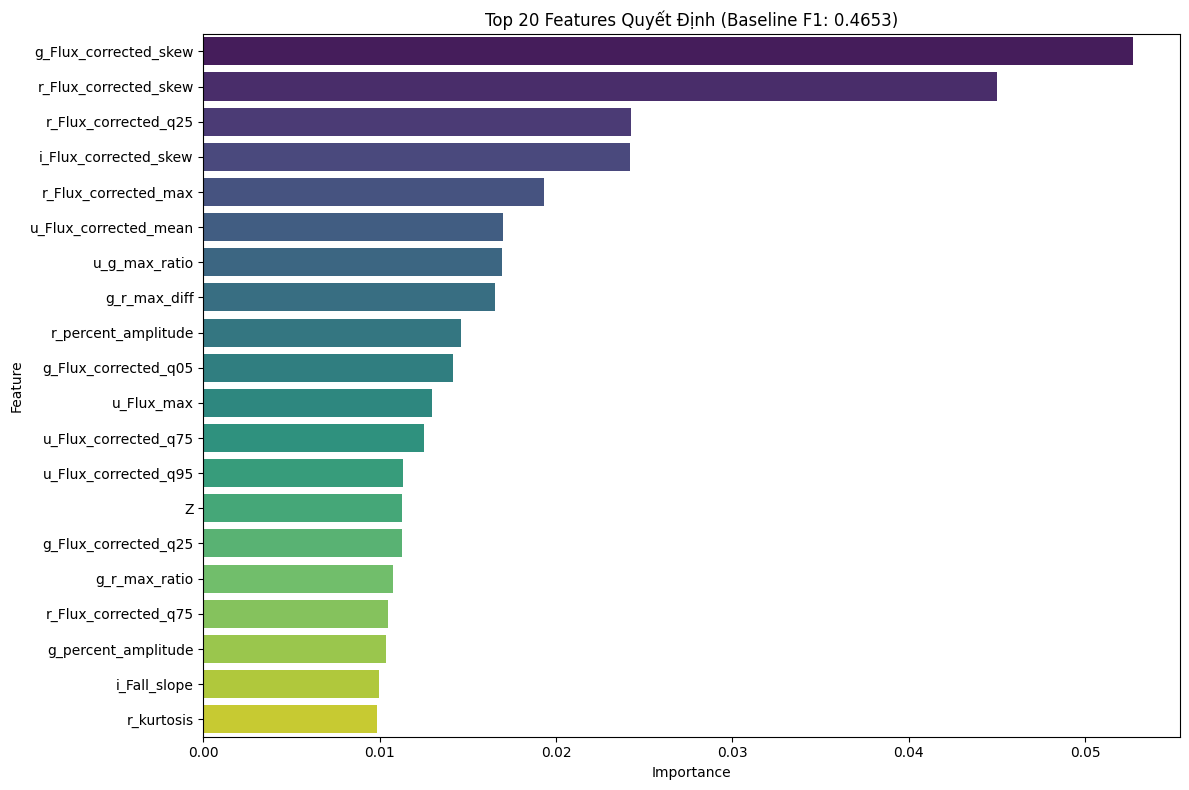


--- TOP 10 FEATURES QUAN TRỌNG NHẤT ---
              Feature  Importance
g_Flux_corrected_skew    0.052742
r_Flux_corrected_skew    0.044973
 r_Flux_corrected_q25    0.024250
i_Flux_corrected_skew    0.024202
 r_Flux_corrected_max    0.019309
u_Flux_corrected_mean    0.017012
        u_g_max_ratio    0.016911
         g_r_max_diff    0.016511
  r_percent_amplitude    0.014603
 g_Flux_corrected_q05    0.014136


In [24]:
avg_f1 = np.mean(f1_scores)
print(f"Average F1-Score (Baseline): {avg_f1:.4f}")

# Vẽ top 20 Features
avg_imp = np.mean(feature_importance_list, axis=0)
feat_df = pd.DataFrame({"Feature": X.columns, 'Importance':avg_imp})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12,8))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
plt.title(f'Top 20 Features Quyết Định (Baseline F1: {avg_f1:.4f})')
plt.tight_layout()
plt.show()

print("\n--- TOP 10 FEATURES QUAN TRỌNG NHẤT ---")
print(feat_df[['Feature', 'Importance']].head(10).to_string(index=False))